In [89]:
import torch
import torch.backends.cudnn as cudnn
device = torch.cuda.set_device('cuda:0')
import matplotlib.pyplot as plt
from skimage.io import imread 
from skimage.transform import resize
import numpy as np
from utils import *
from skimage.io import imread
import cv2
import archs

In [90]:
model = archs.NestedUNet(num_classes=3, input_channels=3, deep_supervision=False)
model = model.cuda()
#Load save model
model.load_state_dict(torch.load('/lfs/jonas/unetplus/model.pth'))
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
    

In [91]:
network_size = (512,512,3)
overlap = 0

In [92]:
image2 = imread('200328_fbnc_74_color_dup_R1C1.tif')
#image2 = imread('200414_fbnc_74_pan_clo_R1C1.tif')
#img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
img2 = image2
#img2 = img2.reshape(img2.shape + (1,))
print(img2.shape)
image_size = list(image2.shape[0:2]) #Get image size and push to a list
tile_size = list(network_size[0:2]) #Get tile size as first two dimensions of network_size
        
corners = find_corners(image_size, tile_size, network_size, overlap)

img2 = image2

mean_ch = img2.mean()
std_ch = img2.std()
img2 = (img2 - mean_ch) / (std_ch)
#img2 = np.tanh(((img2 - img2.mean()))/img2.std())
tilesArr2 = create_tiles(img2, corners, network_size)
print(tilesArr2.shape)

(1014, 2115, 3)
(10, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


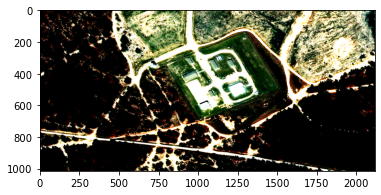

In [93]:
plt.imshow(img2)

In [94]:
tilesArr2 = tilesArr2.astype('float32')
tilesArr2 = tilesArr2.transpose(0, 3, 1, 2)
tilesArr2 = torch.from_numpy(tilesArr2)
tilesArr2 = tilesArr2.cuda()

In [95]:
tilesArr2.shape

torch.Size([10, 3, 512, 512])

In [96]:
output = []
for tile in tilesArr2:
    tile = tile.reshape((1,) + tile.shape)
    with torch.no_grad():
        pred = model(tile)
        pred = torch.sigmoid(pred).cpu().numpy()
        torch.cuda.empty_cache()
    pred = pred.reshape(pred.shape[1], pred.shape[2], pred.shape[3])
    output += [pred]
output = np.array(output)

In [97]:
output.shape

(10, 3, 512, 512)

In [98]:
final_back = assemble_pred(output[:,0,:,:], corners, image2, network_size)

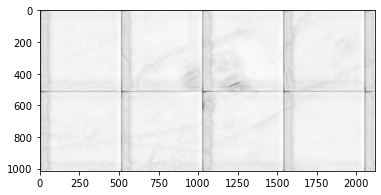

In [99]:
plt.imshow(final_back, cmap="gray")

In [100]:
final_mask = assemble_pred(output[:,1,:,:], corners, image2, network_size)

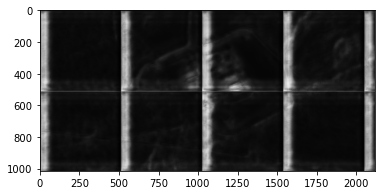

In [101]:
plt.imshow(final_mask, cmap="gray")

In [102]:
final_edge = assemble_pred(output[:,2,:,:], corners, image2, network_size)

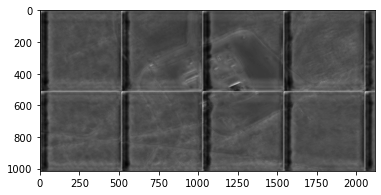

In [103]:
plt.imshow(final_edge, cmap="gray")

In [104]:
def act_thr_bool(img):
    import numpy as np
    import cv2
    img_act = np.tanh(img) * 255
    img_act = img_act.astype(np.uint16)
    _, img_th = cv2.threshold(img_act,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return np.array(img_th, dtype=np.bool)

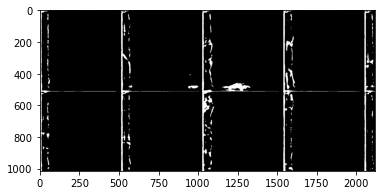

In [105]:
back = act_thr_bool(final_back)
bldg = act_thr_bool(final_mask)
edge = act_thr_bool(final_edge)

final = np.zeros(shape=image2.shape)
#final[edge] = 1
final[bldg] = 1
final[back] = 0

plt.imshow(final, cmap = 'gray')

In [106]:
import rasterio as rio
file = '/data/spacenet/bldg/data/pytorch-RGB/images/RGB-PanSharpen_AOI_2_Vegas_img1.tif'
rast = rio.open(file)
rast_img = rast.read((1,2,3)).transpose(1,2,0)
rast_img.shape

(650, 650, 3)

In [107]:
ski = imread(file)

In [108]:
ski.all() == rast_img.all()

True